 ## 5.3 Cross-Validation and Regularization
 
 In practical applications the ground truth function will not be given, yet we still have to find a way to balance bias and variance of our models. In order to judge these statistics, one can either keep a disjunct validation set or apply cross-validation if training data is scarce. It is also good practice to keep an additional test set, that is untouched for optimization, in order to judge future performance. The most common method against overfitting is keeping the L2-Norm of the weights as small as possible (also known as Ridge Regression for linear models). This exercise will let you explore the relationship between these concepts.

**Task a) Cross-validation and Regularization.**
  * Implement Ridge Regression for polynomial models. Don't use sklearn here!
  * Implement 3-fold cross-validation and calculate training and validation errors.
  
**Q 5.3.1: What is the effect of the regularization weight on the different evaluation statistics (training, cross-validation and test-error)?**

**My take**
- Generate synthetic training sample with n_folds x n_samles per fold
- Randomly distributed over x axis with exact y values
- loop: 
    - split k_fold times into  partitions for cross validation
    - fit polynomial model for each resulting (k_fold - 1) validation set, using L_2 regularisation
- test result with test data

In [1]:
%%capture
%run '5.1 Bias-Variance Analysis.ipynb'
# We silently run your solution to the first exercise to have
# the previously defined functions and data available.

In [2]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

n_folds = 3
n_samples = 2 # actually samples per fold - total of samples is n_samples x n_folds
poly_degree = 3

# We draw the points - as before - from a sine curve
# abwechselnd positive und negative, alle in Range 0.1 bis 0.9
# shape (k_folds, n_samples, n_features) = (3,1,1)
X_cv = np.array([np.random.uniform(0.1, 0.9, size=(n_samples, 1)) * (-1)**i for i in range(n_folds)])
print("X_cv",X_cv)
print("X_cv.shape",X_cv.shape)
print("X_cv.ndim",X_cv.ndim)

y_cv = np.array([target(X_cv[i]) for i in range(n_folds)])
print("y_cv",y_cv)

X_test = np.array([-0.97, -0.4, 0.7, 0.97]).reshape((-1, 1))   # shaped a two dim array, with second dim (columns) = 1, first dim takes automatically necessary size to accomdate all elements 
#print("X_test",X_test)
y_test = target(X_test)

X_cv [[[ 0.19138976]
  [ 0.39624488]]

 [[-0.58208193]
  [-0.47786652]]

 [[ 0.6983734 ]
  [ 0.77751488]]]
X_cv.shape (3, 2, 1)
X_cv.ndim 3
y_cv [[[ 0.56568909]
  [ 0.94734493]]

 [[-0.96693588]
  [-0.99758346]]

 [[ 0.81201007]
  [ 0.64342008]]]


Regularization weight: 1.0e+00
Average training error: 0.243
Cross-validation error: 0.538
Average test error: 0.518


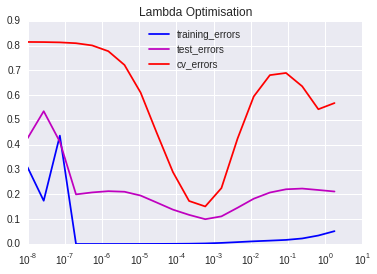

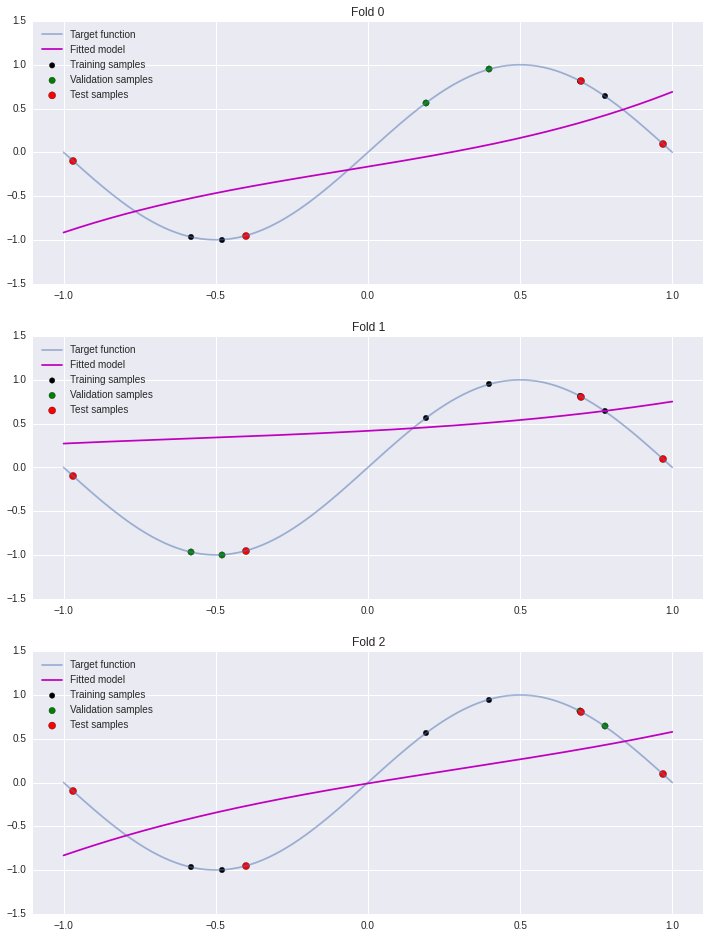

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
try: import seaborn as sns
except ImportError: pass

# Calculate the root mean square error, input 2 arrays shape (n_samples)
def rmse(y, y_predicted):
    return np.sqrt(np.mean(0.5 * (y - y_predicted)**2))


# copied from 5.1, not necessary
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=True)
add_polynomials = poly_features.fit_transform

# Ridge regression is an extension of linear least squares.
# How do you have to adjust the linear fitting function for this?
# Remember to augment the dataset for polynomial features as before.
# least square loss function with L_2 regularisation
# closed for solution for ridge regression w = (lambda*I + PHI.T*PHI)^-1 PHI.T*y
# where PHI are the augmented features (after application of basis functions)
def fit_ridge_regression(X, y, regularization_weight):
    verify_shapes(X, y)
    
    # augment = add basis functions
    X_aug = add_polynomials(X)   # fügt spalte 0 mit 1-sen dazu, plus spalte 2 und 3 mit quadrat und hoch3 
    # print("X_aug with polynomials \n", X_aug)

    regularization_term = (1e-10 + regularization_weight) * np.eye(X_aug.shape[1])
    

    # This is the new part. It adds a weighted identity term to the data matrix
    # Add an epsilon to make inversion stable
    # see lecture slide 15 forumula at the bottom 
    
    # my turn, equivalent, in one term
    # weights = np.dot(np.linalg.inv(regularization_term + np.dot(X_aug.T,X_aug)),np.dot(X_aug.T,y)) # regul_weight broadcasted

    inverse = np.linalg.inv(regularization_term + X_aug.T.dot(X_aug))
    weights = inverse.dot(X_aug.T).dot(y)
    
    return weights


# We can use the same method to evaluate a ridge regression
# model as in exercise 5.1.

# Bookkeeping
training_errors = np.zeros((n_folds))
validation_errors = np.zeros((n_folds))
test_errors = np.zeros((n_folds))
models = np.zeros((n_folds, poly_degree + 1, 1))

# Here we define our cross-validation function specialized for
# our ridge regression models. The regularization weight is
# the only hyperparameter.
def cross_validate(regularization_weight):
 
    # Loop over the validation folds
    for i in range(n_folds):
        # Split the data into training and validation set
        # You can use the mask to select the correct training folds
        # X_cv[mask] will give you all folds except for the i-th one
        mask = np.arange(n_folds) != i  # mask [ True False  True]
        
        # Remember the correct shape (n_samples, n_features)
        
        # X_cv.shape (3, 1, 1) --> eindampfen auf 2 dimensionen 
        # erste steht für k_fold --> weg, zweite und dritte für n_samples und n_features (hier beides 1)
        # reshape (-1, 1) belässte hinterste (1), und 
        # One shape dimension can be -1. In this case, the value is inferred from the length of the array 
        # and remaining dimensions.
        X_train = X_cv[mask].reshape((-1, 1)) 
        y_train = y_cv[mask].reshape((-1, 1))   # shape (k_folds x n_samples, 1)
        # print("y-train", y_train)
        verify_shapes(X_train, y_train)
    
        X_valid = X_cv[i] # returns the array of sample of this fold (dimension of k_fold vanishes)
        # print(("X_valid", X_valid.shape))
        y_valid = y_cv[i]
        verify_shapes(X_valid, y_valid)
    
        # Train a model and determine the training and validation error
        w = fit_ridge_regression(X_train, y_train, regularization_weight)  # return (4,1)
        models[i] = w # (3,4,1)                                                    
        
        # Calculate the training, validation and test error
        # for the model trained in this fold
        # The models can be evaluated with eval_polynomial function
        # from the first part. We already wrote an error function
        # for comparing it to the ground truth

        # evaluate model on training data
        X_aug = add_polynomials(X_train)
        y_pred = X_aug.dot(w)
        # print("y-pred", y_pred.shape)       

        training_errors[i] = rmse(y_train,y_pred)
        validation_errors[i] = rmse(y_valid,add_polynomials(X_valid).dot(w))  # same, directly in one line
        test_errors[i] = rmse(y_test,eval_polynomial(X_test, w)) # same, more elegant using eval poly function
            
    # Calculate the statistics for the whole procedure
    # This reduces to taking the mean over the folds
    # The cross-validation error is the measure we're after!
    avg_training_error = np.mean([training_errors])
    cross_validation_error = np.mean([validation_errors])
    avg_test_error = np.mean([test_errors])
    return avg_training_error, cross_validation_error, avg_test_error



# TODO: Set the strength of the regularisation here
regularization_weight = 1
avg_training_error, cross_validation_error, avg_test_error = \
    cross_validate(regularization_weight)

#print("models", models)    
    
# Show the statistics for this model class
print('Regularization weight: {:.1e}'.format(regularization_weight))
print('Average training error: {:.3f}'.format(avg_training_error))
print('Cross-validation error: {:.3f}'.format(cross_validation_error))
print('Average test error: {:.3f}'.format(avg_test_error))

# screening hyperparameter space looking for sweet spot for regularisation Lambda

# book-keeping
gridlength = 20
lambdas = np.zeros(gridlength)
training_errors = np.zeros(gridlength)
CV_errors = np.zeros(gridlength)
test_errors = np.zeros(gridlength)

for i in range(gridlength):
    lambdas[i] = (1.0e-08)*np.exp(i)
    training_errors[i], CV_errors[i], test_errors[i] = cross_validate(lambdas[i])
    #print('regul: {:.1e}, train: {:.3f}, cross_valid: {:.3f}, test: {:.3f}' \
    #      .format(lambdas[i], training_errors[i], CV_errors[i], test_errors[i]))


#fix, axes = plt.subplots(n_folds, 1, figsize=(12, 16))
#X_eval = np.linspace(-1, 1, 200).reshape((-1, 1))
#y_eval = np.sin(np.pi * X_eval)

plt.title('Lambda Optimisation')
plt.plot(lambdas, training_errors, label='training_errors', c='b')
plt.plot(lambdas, test_errors, label='test_errors', c='m')
plt.plot(lambdas, CV_errors, label='cv_errors', c='r')
plt.xscale('log') 
plt.legend(loc='best')
plt.show

# Plotting: For 3 folds, we can still look at each model and how
# well it fits the different data sets.
fix, axes = plt.subplots(n_folds, 1, figsize=(12, 16))
X_eval = np.linspace(-1, 1, 200).reshape((-1, 1))
y_eval = np.sin(np.pi * X_eval)
for i, axis in enumerate(axes):
    axis.set_title('Fold {:d}'.format(i))
    axis.plot(X_eval, np.sin(np.pi * X_eval), label='Target function', alpha=0.5)
    if not np.any(np.isnan(models[i])):
        axis.plot(X_eval, eval_polynomial(X_eval, models[i]),
                  label='Fitted model', c='m')
    mask = np.arange(n_folds) != i
    axis.scatter(X_cv[mask].flatten(), y_cv[mask].flatten(),
                 label='Training samples', s=30, c='k')
    axis.scatter(X_cv[i].flatten(), y_cv[i].flatten(),
                 label='Validation samples', s=40, c='g')
    axis.scatter(X_test.flatten(), y_test.flatten(),
                 label='Test samples', s=50, c='r')
    axis.set_xlim((-1.1, 1.1))
    axis.set_ylim((-1.5, 1.5))
    axis.legend(loc='best')